In [1]:
# Data hosted at below link (downloading it)
!wget https://www.dropbox.com/s/tlxserrdhe240lu/archive.zip


--2021-12-18 13:52:51--  https://www.dropbox.com/s/tlxserrdhe240lu/archive.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/tlxserrdhe240lu/archive.zip [following]
--2021-12-18 13:52:51--  https://www.dropbox.com/s/raw/tlxserrdhe240lu/archive.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc33fd1244f2d3ad17b41e9b1cee.dl.dropboxusercontent.com/cd/0/inline/BcErF2z0uwdNr7v9n4WKTzsYnIgbO2Ls39jyZTsvG9353XOPUrZRqVwyxrcFMOXnSfpe8q0Y0B96D0i9JNcUCx0Bvd9wF1Z-SPo_qSdl7YnwmNtefLsOlKrGXZz5cjogU21CysG09hEFCUKa981U4tkL/file# [following]
--2021-12-18 13:52:51--  https://uc33fd1244f2d3ad17b41e9b1cee.dl.dropboxusercontent.com/cd/0/inline/BcErF2z0uwdNr7v9n4WKTzsYnIgbO2Ls39jyZTsvG9353XOPUrZRqVwyxrcFMOXnSfpe8q0Y0B96D0i9JNcUCx0Bvd

In [2]:
# Unzipping the data
!unzip -q "archive.zip"

In [3]:
# Imports required for this project
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

tf.random.set_seed(4)

In [4]:
# Creating the Pathlib PATH objects
train_path = Path("chest_xray/train/")
validation_path = Path("chest_xray/test")
test_path = Path("chest_xray/val")

In [5]:
# Collecting all the Paths Inside "Normal" and "Pneumonia" folders of the above paths
train_image_paths = train_path.glob("*/*")
val_image_paths = validation_path.glob("*/*")

# Output is a Generator object
print(train_image_paths)

<generator object Path.glob at 0x7fcd1ea07f50>


In [6]:
# Convert Generator Object to List of elements 
train_image_paths = list(train_image_paths)
val_image_paths = list(val_image_paths)

# Now the outputs are "PosixPath" objects
print(train_image_paths[:3])

[PosixPath('chest_xray/train/PNEUMONIA/person582_bacteria_2405.jpeg'), PosixPath('chest_xray/train/PNEUMONIA/person114_virus_217.jpeg'), PosixPath('chest_xray/train/PNEUMONIA/person435_virus_885.jpeg')]


In [7]:
# Convert Posix paths to normal strings
train_image_paths = list(map(lambda x : str(x) , train_image_paths))
val_image_paths = list(map(lambda x : str(x) , val_image_paths)) 

print(train_image_paths[:3])

['chest_xray/train/PNEUMONIA/person582_bacteria_2405.jpeg', 'chest_xray/train/PNEUMONIA/person114_virus_217.jpeg', 'chest_xray/train/PNEUMONIA/person435_virus_885.jpeg']


In [8]:
# Collect Length for Training and Validation Datasets
train_dataset_length = len(train_image_paths)
val_dataset_length = len(val_image_paths)

In [9]:
# Every Image has Label in its path , so lets slice it 
LABELS = {'NORMAL' : 0 , 'PNEUMONIA' : 1}
INV_LABELS = {0 : 'NORMAL', 1 : 'PNEUMONIA'}

def get_label(path : str) -> int:
    return LABELS[path.split("/")[-2]]

train_labels = list(map(lambda x : get_label(x) , train_image_paths))
val_labels = list(map(lambda x : get_label(x) , val_image_paths))

print(train_labels[:3])

[1, 1, 1]


In [10]:
# Now we have all training, validation image paths and their respective labels 

BATCH_SIZE = 32

# Function used for Transformation
def load_and_transform(image , label , train = True):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    image = tf.image.resize(image , [224 , 224] , method="nearest")
    if train:
        image = tf.image.random_flip_left_right(image)
    return image , label

# Function used to Create a Tensorflow Data Object
def get_dataset(paths , labels , train = True):
    image_paths = tf.convert_to_tensor(paths)
    labels = tf.convert_to_tensor(labels)

    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)

    dataset = tf.data.Dataset.zip((image_dataset , label_dataset)).shuffle(1000)

    dataset = dataset.map(lambda image , label : load_and_transform(image , label , train))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)

    return dataset

In [11]:
# Creating Train Dataset object and Verifying it
%time train_dataset = get_dataset(train_image_paths , train_labels)

image , label = next(iter(train_dataset))
print(image.shape)
print(label.shape)

CPU times: user 712 ms, sys: 381 ms, total: 1.09 s
Wall time: 3.61 s
(32, 224, 224, 3)
(32,)


PNEUMONIA


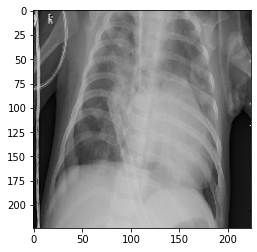

In [12]:
# View a sample Train Image
print(INV_LABELS[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224 , 224 , 3))

In [13]:
%time val_dataset = get_dataset(val_image_paths , val_labels , train = False)

image , label = next(iter(val_dataset))
print(image.shape)
print(label.shape)

CPU times: user 16.1 ms, sys: 0 ns, total: 16.1 ms
Wall time: 19.6 ms
(32, 224, 224, 3)
(32,)


PNEUMONIA


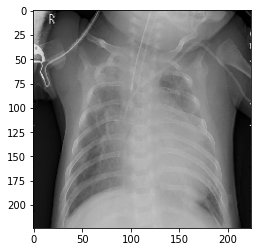

In [14]:
# View a sample Validation Image
print(INV_LABELS[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224 , 224 , 3))

In [15]:
# Building model with CNN without pretrained models
model = tf.keras.models.Sequential([
# Note the input shape is the desired size of the image 200x200 with 3 bytes color
# This is the first convolution
tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(224, 224, 3)),
tf.keras.layers.MaxPooling2D(2, 2),
# The second convolution
tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
# The third convolution
tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
# The fourth convolution
tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
# # The fifth convolution
tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
# Flatten the results to feed into a DNN
tf.keras.layers.Flatten(),
# 512 neuron hidden layer
tf.keras.layers.Dense(512, activation='relu'),
# Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('Normal') and 1 for the other ('Pneumonia')
tf.keras.layers.Dense(1, activation='sigmoid')])
#model.compile(loss='binary_crossentropy',optimizer=RMSprop(lr=0.001),metrics='accuracy')

# We can use ResNet50 pretrained model also

# Building ResNet50 model
# from tensorflow.keras.applications import ResNet50V2

# backbone = ResNet50V2(
#     input_shape=(224, 224, 3),
#     include_top=False
# )

# model = tf.keras.Sequential([
#     backbone,
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

In [16]:
# Compiling your model by providing the Optimizer , Loss and Metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'binary_crossentropy',
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)

In [17]:
# Defining our callbacks 
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights.h5",verbose=1,save_best_only=True,save_weights_only = True)
early_stop = tf.keras.callbacks.EarlyStopping(patience=4)

In [18]:
# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset_length//BATCH_SIZE,
    epochs=4,
    callbacks=[checkpoint , early_stop],
    validation_data=val_dataset,
    validation_steps = val_dataset_length//BATCH_SIZE,
)

Epoch 1/4
163/163 [==============================] - ETA: 0s - loss: 1.6335 - accuracy: 0.8888 - precision: 0.9191 - recall: 0.9454
Epoch 00001: val_loss improved from inf to 0.51688, saving model to best_weights.h5
163/163 [==============================] - 73s 321ms/step - loss: 1.6335 - accuracy: 0.8888 - precision: 0.9191 - recall: 0.9454 - val_loss: 0.5169 - val_accuracy: 0.7993 - val_precision: 0.7766 - val_recall: 0.9612
Epoch 2/4
163/163 [==============================] - ETA: 0s - loss: 0.1445 - accuracy: 0.9456 - precision: 0.9579 - recall: 0.9693
Epoch 00002: val_loss did not improve from 0.51688
163/163 [==============================] - 51s 312ms/step - loss: 0.1445 - accuracy: 0.9456 - precision: 0.9579 - recall: 0.9693 - val_loss: 0.9920 - val_accuracy: 0.7418 - val_precision: 0.7038 - val_recall: 0.9919
Epoch 3/4
163/163 [==============================] - ETA: 0s - loss: 0.0983 - accuracy: 0.9630 - precision: 0.9755 - recall: 0.9752
Epoch 00003: val_loss did not improve

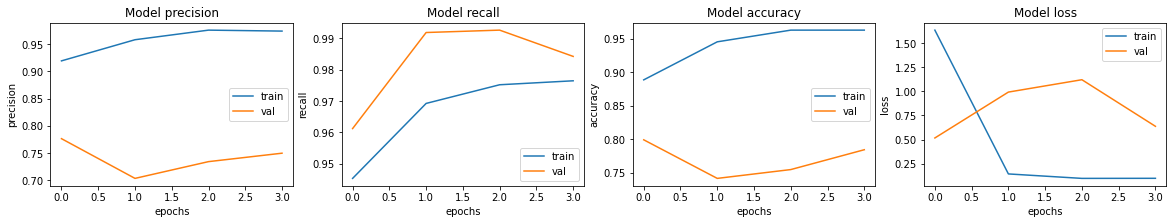

In [19]:
# Interpreting the Metrics 
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [20]:
# Saving the best Model

# Load the best weights
model.load_weights("best_weights.h5")
# Save the whole model (weigths + architecture)
model.save("model.h5")

In [21]:
# Loading the whole model
loaded_model = tf.keras.models.load_model("model.h5")

Create a Testing Dataset

In [22]:
# Create a Dataset Object for 'Testing' Set just the way we did for Training and Validation
test_image_paths = list(test_path.glob("*/*"))
test_image_paths = list(map(lambda x : str(x) , test_image_paths))
test_labels = list(map(lambda x : get_label(x) , test_image_paths))

test_image_paths = tf.convert_to_tensor(test_image_paths)
test_labels = tf.convert_to_tensor(test_labels)

def decode_image(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    image = tf.image.resize(image , [224 , 224] , method="nearest")
    return image , label

test_dataset = (
     tf.data.Dataset
    .from_tensor_slices((test_image_paths, test_labels))
    .map(decode_image)
    .batch(BATCH_SIZE)
)

In [23]:
# Verify Test Dataset Object
image , label = next(iter(test_dataset))
print(image.shape)
print(label.shape)

(16, 224, 224, 3)
(16,)


PNEUMONIA


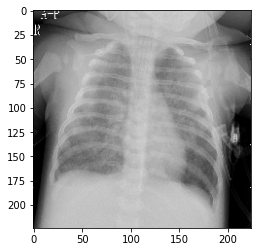

In [24]:
# View a sample Validation Image
print(INV_LABELS[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224 , 224 , 3))

In [25]:
# Evaluating the loaded model
loss, acc, prec, rec = loaded_model.evaluate(test_dataset)

print(" Testing Acc : " , acc)
print(" Testing Precision " , prec)
print(" Testing Recall " , rec)

1/1 [==============================] - 0s 449ms/step - loss: 0.9095 - accuracy: 0.6250 - precision: 0.5714 - recall: 1.0000
 Testing Acc :  0.625
 Testing Precision  0.5714285969734192
 Testing Recall  1.0
